# Logistic Regression with Pytorch

Allright, everyone. Let's go ahead and start doing things. We will start with a brief review, so that we are all on the same page.

## Review: Logistic Regression with Scikit-Learn

If you have reached this point, you probably know by heart how to define a Logistic Regression pipeline in Scikit Learn:


In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

vectorizer = CountVectorizer(binary=True)
classifier = LogisticRegression()
pipeline = Pipeline([("vectorizer", vectorizer),
                        ("classifier", classifier)])

Remember that when we call `pipeline.fit()`, we first fit the vectorizer and then, with the results, we fit the classifier. So, these two methods for training our model are absolutely equivalent:

In [3]:
def train_the_pipeline(pipeline, X_train, y_train):
    pipeline.fit(X_train, y_train)
    return pipeline

def train_each_part_separately(vectorizer, classifier, X_train, y_train):
    X_train_vectorized = vectorizer.fit_transform(X_train)
    classifier.fit(X_train_vectorized, y_train)
    return vectorizer, classifier

In fact, we could go ahead and have our model trained, so that the next steps in this lesson are going to be a bit smoother. We could fit our model to classify some texts with our usual dataset:

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

df = pd.read_csv('https://raw.githubusercontent.com/tiagoft/NLP/refs/heads/main/wiki_movie_plots_drama_comedy.csv').sample(1000)
X_train, X_test, y_train, y_test = train_test_split(df['Plot'], df['Genre'], test_size=0.2, random_state=42)
vectorizer, classifier = train_each_part_separately(vectorizer, classifier, X_train, y_train)
X_vect = vectorizer.transform(X_test)
y_pred = classifier.predict(X_vect)
print(accuracy_score(y_test, y_pred))

0.67


Now, let's recall how Logistic Regression works!

The fitted predictor expects an input with $d$ features.

We use the `vectorizer` to map each text in `X_test` to a vector with $d$ elements. Each of these vectors is a line $[x_1, x_2, x_3 \cdots x_d]$ in `X_vect` (note that the index $d$ in $x_d$ is the same as the number of features expected by the fitted predictor.

Then, Logistic Regression uses its fitter weights $\beta$ to calculate a weighted sum of the elements in the input, that is:

$$
z = \beta_0 + x_1 \beta_1 + x_2 \beta_2 + \cdots + x_d \beta_d.
$$

Note that if we have a matrix made of $N$ lines of features (each line corresponding to a dataset item!), then we can calculate the output for each line $i$ using:

$$
z_i = \beta_0 + x_{i,1} \beta_1 + x_{i,2} \beta_2 + \cdots + x_{i,d} \beta_d.
$$

This can be translated into a matrix multiplication:

$$
\begin{bmatrix}
z_1 \\
z_2 \\
\cdots \\
z_N \end{bmatrix} = \beta_0 + \begin{bmatrix} 
                        x_{1,1} & x_{1,2} & \cdots & x_{1,d} \\
                        x_{2,1} & x_{2,2} & \cdots & x_{2,d} \\
                        \cdots & \cdots & \cdots & \cdots \\
                        x_{N,1} & x_{N,2} & \cdots & x_{N,d} \\
                        \end{bmatrix}
                        \begin{bmatrix}
                        \beta_1 \\
                        \beta_2 \\
                        \cdots \\
                        \beta_d
                        \end{bmatrix}.
$$

We can simplify this by defining a weight matrix $w = [\beta_1, \beta_2, \cdots, \beta_d]$, and an input matrix $X$ containing all elements $x_{i,j}$ so that:

$$
z = \beta_0 + X w^T
$$

Last, we apply the logistic function to each element of the vector $z$, and then we have a prediction.

The elements of $z$ are called *logits*, $\beta_0$ is called *bias* and the elements of $w$ are called *weights*.

Good, but we didn't come this far to hear again about Logistic Regression. We now shall proceed!

## Our first model with Pytorch

If you haven't done so, this is the moment to `pip install torch`. Pytorch is a framework that provides an API similar to Numpy with the addition of allowing operations in the GPU and easily using Autograd. Also, it contains many classes that are very useful for applications in Machine Learning. For example:


In [ ]:
import torch.nn as nn
linear_layer = nn.Linear(in_features=3, out_features=1)
print(linear_layer)

Linear(in_features=3, out_features=1, bias=True)


A linear layer takes something as an input $X$, multiplies it by a weight matrix $w$ and sums a bias $b$. In other words:

$$
z = \beta_0 + X w^T
$$

Sounds familiar? Let's see this operation working in practice:


In [6]:
import torch
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])

# We can call the linear_layer, and it will perform its operation:
output = linear_layer(X)
print(output)

# We can also access the weights and biases of the linear layer:
w = linear_layer.weight
b = linear_layer.bias
print(w, b)

# We can use these weights and biases to perform the operation manually:
z = X @ w.T + b
print(z)

tensor([[-0.2425],
        [-0.3668]], grad_fn=<AddmmBackward0>)
Parameter containing:
tensor([[-0.1708, -0.0364,  0.1658]], requires_grad=True) Parameter containing:
tensor([-0.4963], requires_grad=True)
tensor([[-0.2425],
        [-0.3668]], grad_fn=<AddBackward0>)


    
Note that we defined the size of the weight matrix using the `in_features` and `out_features` in our linear layer. The number `in_features` is the dimension of the input (probably our $d$), and `out_features` allows us to calculate several $z_j$ vectors simultaneously and independently. For example, having `in_features=2` and `out_features=3` leads to:

$$
\begin{bmatrix}
z_{1,1} & z_{1,2} & z_{1,3} \\
z_{2,1} & z_{2,2} & z_{2,3} \\
\cdots \\
z_{N, 1} & z_{N,2} & z_{N,3} \end{bmatrix} = \beta_0 + \begin{bmatrix} 
                        x_{1,1} & x_{1,2} & \cdots & x_{1,d} \\
                        x_{2,1} & x_{2,2} & \cdots & x_{2,d} \\
                        \cdots & \cdots & \cdots & \cdots \\
                        x_{N,1} & x_{N,2} & \cdots & x_{N,d} \\
                        \end{bmatrix}
                        \begin{bmatrix}
                        \beta_{1,1} & \beta_{1,2} & \beta{1,3}\\
                        \beta_{2,1} & \beta_{2,2} & \beta{2,3}\\
                        \cdots \\
                        \beta_{d,1} & \beta_{d,2} & \beta_{d,3}
                        \end{bmatrix}.
$$


A linear layer takes something as an input $X$, multiplies it by a weight matrix $w$ and sums a bias $b$. In other words:

$$
z = \beta_0 + X w^T
$$

Sounds familiar? Let's see this operation working in practice:

In [7]:
import torch
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])

# We can call the linear_layer, and it will perform its operation:
output = linear_layer(X)
print(output)

# We can also access the weights and biases of the linear layer:
w = linear_layer.weight
b = linear_layer.bias
print(w, b)

# We can use these weights and biases to perform the operation manually:
z = X @ w.T + b
print(z)

tensor([[-0.2425],
        [-0.3668]], grad_fn=<AddmmBackward0>)
Parameter containing:
tensor([[-0.1708, -0.0364,  0.1658]], requires_grad=True) Parameter containing:
tensor([-0.4963], requires_grad=True)
tensor([[-0.2425],
        [-0.3668]], grad_fn=<AddBackward0>)


    
Note that we defined the size of the weight matrix using the `in_features` and `out_features` in our linear layer. The number `in_features` is the dimension of the input (probably our $d$), and `out_features` allows us to calculate several $z_j$ vectors simultaneously and independently. For example, having `in_features=2` and `out_features=3` leads to:

$$
\begin{bmatrix}
z_{1,1} & z_{1,2} & z_{1,3} \\
z_{2,1} & z_{2,2} & z_{2,3} \\
\cdots \\
z_{N, 1} & z_{N,2} & z_{N,3} \end{bmatrix} = \beta_0 + \begin{bmatrix} 
                        x_{1,1} & x_{1,2} & \cdots & x_{1,d} \\
                        x_{2,1} & x_{2,2} & \cdots & x_{2,d} \\
                        \cdots & \cdots & \cdots & \cdots \\
                        x_{N,1} & x_{N,2} & \cdots & x_{N,d} \\
                        \end{bmatrix}
                        \begin{bmatrix}
                        \beta_{1,1} & \beta_{1,2} & \beta{1,3}\\
                        \beta_{2,1} & \beta_{2,2} & \beta{2,3}\\
                        \cdots \\
                        \beta_{d,1} & \beta_{d,2} & \beta_{d,3}
                        \end{bmatrix}.
$$

or, more compactly:

$$
z_{N \times J} = x_{N \times d} w^T_{d \times j} + b_{1 \times j}
$$

Note that $w \in \mathbb{R}^{j \times d}$, hence $w^T \in \mathbb{R}^{d \times j}$.


### Exercise 1

In the formulation for the linear layer above, $z$ corresponds to an important part of a logistic regression (remember: logistic regression has an input, a decision function, and then a final probability estimate $P(C | x)$). Which of these parts corresponds to the linear layer operation, and what is missing to make a full logistic regression using the linear layer?

## A linear layer is a linear predictor?

Allright, so the linear layer works essentially the same as the logistic regression. Let's show it!

First, get back to the classifier we made in the beginning of this class. If you haven't fitted it yet, do it now.

In the code below, we get the weights from the fitted logistic regression and substitute them in our linear layer:


In [8]:
logistic_w = classifier.coef_
logistic_b = classifier.intercept_

w = torch.tensor(logistic_w, dtype=torch.float32)
b = torch.tensor(logistic_b, dtype=torch.float32)

linear_layer.weight.data = w
linear_layer.bias.data = b

Now, we can run the linear layer with `X_vect` and then apply a logistic function:

In [9]:
X_vect_tensor = torch.tensor(X_vect.toarray(), dtype=torch.float32)
output = linear_layer(X_vect_tensor)
output_probs = torch.sigmoid(output)

Note that our `output_probs` here is equal to the second column of the output of `classifier.predict_proba()`:

In [10]:
y_probs = classifier.predict_proba(X_vect)
print(y_probs[:5])
print(output_probs[:5])

[[0.15291863 0.84708137]
 [0.05730017 0.94269983]
 [0.86117739 0.13882261]
 [0.02964921 0.97035079]
 [0.03383664 0.96616336]]
tensor([[0.8471],
        [0.9427],
        [0.1388],
        [0.9704],
        [0.9662]], grad_fn=<SliceBackward0>)


In fact, we could simply decide our class by thresholding our output:

In [11]:
binary_out = (output_probs > 0.5).numpy().astype(int)
binary_y = (y_test==classifier.classes_[1]).astype(int)
print(accuracy_score(binary_y, binary_out))

0.67


## How to train a Logistic Regression

Remember that our classifier outputs:


$$
\hat{y} = \sigma(z) = \sigma(Xw^T + b),
$$
where $\sigma()$ denotes the sigmoid (or logistic) function?

The procedure to adjust the weights and biases in our linear layer is to use actual examples of outputs ($y$) and compare them to our estimate $\hat{y}$. They are probably not going to be the same, so we can calculate how $y$ and $\hat{y}$ are different using a loss function $L(y, \hat{y})$. Then, we are going to calculate the derivative of $L$ with respect to all weights and biases, that is, we will have:

$$
g_i = \frac{d L}{d p_i}
$$

for each parameter $p_i$ in the linear layer (either a weight or a bias). The parameters in the linear layer are the weights and biases. 

You might have noticed that $g$ is a vector of derivatives. Actually, you might even remember that it is called a *gradient* vector written as $\nabla L$.

Remember that the gradient points towards the direction in which $L$ grows the most if we change the parameters $p$? So, let's do the opposite! We want to decrease our loss, so we will change our parameters by *subtracting* a little bit of the gradient vector, that is, we iteractively update the parameters as:

$$
p_i \leftarrow \alpha \frac{\partial L}{\partial p_i},
$$

where $\alpha$ is a small value of our choice. A lower $\alpha$ means steps will be smaller, which can make it take longer to converge, whereas a higher value can lead to instabilities.

We could be fancier and write this in vector form:

$$
p \leftarrow \alpha \nabla_{\mathbf{p}} L.
$$

What we usually do is to calculate the gradient $g$ for each item in the training data, and then sum (or average?) it before applying the step to the parameters. This process of going through the whole dataset is called *epoch*.

Now, how do we implement this? Let's go!


In [12]:
# First, we prepare our data:
X_vect_train = torch.tensor(vectorizer.transform(X_train).toarray(), dtype=torch.float32)
y_train_ = (y_train == classifier.classes_[1]).astype(int).values
y_train_vect = torch.tensor( y_train_, dtype=torch.float32).reshape( -1, 1)

    
Ok, now we are going to get into an optimization loop. When using Pytorch, we must first define an optimizer - we will use SGD, which is literally the gradient descent algorithm we have seen so far. Then, we will go into a training loop consisting of:

1. Zeroing the gradient in the optimizer to reset its state,
1. Calculate the output of the classifier
1. Claculate the loss related to the output
1. Calculate (going back into the layer!) the gradient of the loss using [autograd](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html)
1. Apply the gradient to our parameters

It goes like this:


In [13]:

# Let's start with a new linear layer:
clf = nn.Linear(in_features=len(vectorizer.vocabulary_), out_features=1)

# We will also define an optimizer:
optimizer = torch.optim.SGD(clf.parameters(), lr=1e-4) # lr is the learning rate - this is our alpha

print("Entering loop")
# And now, this is the training loop:
for epoch in range(5):
    optimizer.zero_grad()
    output = clf(X_vect_train)
    output_probs = torch.sigmoid(output)
    loss = torch.sum( (output_probs-y_train_vect)**2 )
    loss.backward()
    optimizer.step()
    print(loss.item())


Entering loop
198.96621704101562
196.2563934326172
194.41258239746094
192.94187927246094
191.63624572753906


How does pytorch know that gradients should be calculated? Well, they are calculated by default. That is why, in inference (or: in testing), we use `torch.no_grad()` and `model.eval()` - this saves memory, and saves computation time as well:

In [14]:
X_vect_test = torch.tensor(vectorizer.transform(X_test).toarray(), dtype=torch.float32)
y_test_ = (y_test == classifier.classes_[1]).astype(int).values
with torch.no_grad():
    clf.eval()
    y_pred = (torch.sigmoid(clf(X_vect_test)) > 0.5).numpy().astype(int)
print(accuracy_score(y_test_, y_pred))

0.565


## Watching our training process

If you simply increased the number of epochs to 1000 in our loop, you probably had an overflow of `print` statements with the current loss. We probably don't want to see that - rather, we want a figure!

Up until a few years ago, we had to make this figure all by ourselves, with a procedure such as:


In [17]:
from tqdm import tqdm # This will make us a progress bar

clf = nn.Linear(in_features=len(vectorizer.vocabulary_), out_features=1)
optimizer = torch.optim.SGD(clf.parameters(), lr=1e-3) # lr is the learning rate - this is our alpha

# And now, a loop that is equal for everyone:
losses = []
accs = []
for epoch in tqdm(range(10000)):
    optimizer.zero_grad()
    output = clf(X_vect_train)
    output_probs = torch.sigmoid(output)
    loss = torch.mean( (output_probs-y_train_vect)**2 )
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    with torch.no_grad():
        clf.eval()
        y_pred = (torch.sigmoid(clf(X_vect_test)) > 0.5).numpy().astype(int)
        accs.append(accuracy_score(y_test_, y_pred))


100%|██████████| 10000/10000 [01:21<00:00, 123.06it/s]


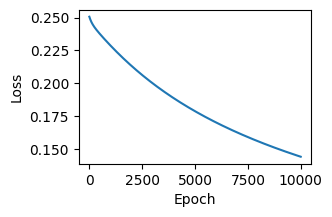

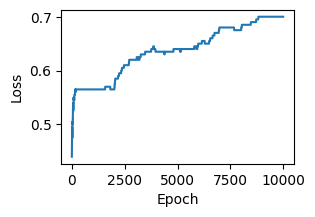

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(3,2))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.figure(figsize=(3,2))
plt.plot(accs)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


crossentropy - classificacao. maximar probalidade de acertar
mean s - regressão. diz o quao longe vc chutou. 


Nowadays, we have plenty of frameworks to store this same data: there is Weights and Biases, MLFlow, TensorBoard, and so on. Please, do feel free to use any of them. We will not adopt any of them for this course because we might get trapped within very specific details of them.


**The main lessons here are:**

* Save your data to a variable, and plot figures later (do NOT plot while doing training!)
* Do not use the terminal to debug your loss
* Use `tqdm` so we know your code is running.

## Exercise 2

Manipulate the code above to find the following:

1. When we use `torch.sum( (output_probs-y_train_vect)**2 )` to calculate the loss, we are essentially saying that larger datasets have larger losses. Change this calculation so the loss is independent of the number of items in the dataset.
1. You might want to increase the learning rate `lr` to make your training faster. What happens if you increase it too much? Can you guess why?
1. Change your code to show that the `accuracy` (at least in the training set) tends to decrease together with the `loss`.
1. How many epochs do you actually need in this training process?